In [3]:
import fitparse # fitparse 1.2.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta

import time
import scipy.signal as signal

print(os.getcwd())

C:\Users\msuzuki\Desktop\Data\Thermal_project\Garmin_data_process


In [184]:
#.Fit data files:
path = 'C:\\Users\\msuzuki\\OneDrive - Specialized Bicycle Components\\Thermal_Project\\Data\\Fit_files_2021'
os.chdir(path)


In [243]:
#Garmin FIT file

fitfile = fitparse.FitFile("After_workout_6161695442_ACTIVITY.fit")

while True:
    try:
        fitfile.messages
        break
    except KeyError:
        continue
        
workout = []
for record in fitfile.get_messages('record'):
    r = {}
    for record_data in record:
        r[record_data.name] = record_data.value
    workout.append(r)

# To_dataFrame
df = pd.DataFrame(workout)

df.position_lat = df.position_lat/((2**32)/360)
df.position_long = df.position_long/((2**32)/360)
df.timestamp = df.timestamp + timedelta(hours=-8) #CA time

#Make timestamp = Index and resample the data with 1sec increment
df.set_index('timestamp', inplace = True)
df.resample('1S').pad()

df.head()

CoreTemp Est Core Temp  altitude  currHemoConc  \
timestamp                                                              
2021-01-24 10:18:07   0.000000          None     106.2             0   
2021-01-24 10:18:08   0.000000          None     106.0             0   
2021-01-24 10:18:09  37.040001          None     106.0          3704   
2021-01-24 10:18:10  37.040001          None     105.6          3704   
2021-01-24 10:18:11  37.040001          None     105.6          3704   

                     currHemoPerc  distance  enhanced_altitude  \
timestamp                                                        
2021-01-24 10:18:07             0      0.00              106.2   
2021-01-24 10:18:08             0      1.14              106.0   
2021-01-24 10:18:09           370      2.01              106.0   
2021-01-24 10:18:10           370      2.51              105.6   
2021-01-24 10:18:11           370      2.74              105.6   

                     enhanced_speed  heart_rate  position_lat  position_long  \
timestamp                                                                      
2021-01-24 10:18:07             0.0          79     37.225227    -121.979851   
2021-01-24 10:18:08             0.0          79     37.225221    -121.979838   
2021-01-24 10:18:09             0.0          78     37.225217    -121.979829   
2021-01-24 10:18:10             0.0          78     37.225208    -121.979833   
2021-01-24 10:18:11             0.0          77     37.225198    -121.979847   

                     speed  temperature  unknown_88  \
timestamp                                             
2021-01-24 10:18:07    0.0           24         300   
2021-01-24 10:18:08    0.0           24         300   
2021-01-24 10:18:09    0.0           24         300   
2021-01-24 10:18:10    0.0           24         300   
2021-01-24 10:18:11    0.0           24         300   

                     saturated_hemoglobin_percent  total_hemoglobin_conc  
timestamp                                                                 
2021-01-24 10:18:07                           NaN                    NaN  
2021-01-24 10:18:08                           NaN                    NaN  
2021-01-24 10:18:09                           NaN                    NaN  
2021-01-24 10:18:10                          68.2                  37.04  
2021-01-24 10:18:11                          68.2                  37.04

In [266]:
#S-CoreT

df_score = pd.read_csv(path+'\S_CoreT\log9.csv', 
                       skiprows = 4,  
                       names=["UTC", "date", "android_time", "freq", "message", "temp", "cal_value"])

df_score.drop(df_score.tail(2).index,inplace=True) # drop last 2 rows to prevent duplicate index

#Elilminate 'ms' from UTC column 
df_score.UTC = df_score.UTC.str[:13].astype('int64')
df_score.UTC = df_score.UTC.apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x/1000)))

##Make timestamp = Index and resample the data with 1sec increment
df_score.UTC = pd.to_datetime(df_score.UTC)
df_score.index = pd.DatetimeIndex(df_score.UTC)
df_score.drop("UTC", axis = 1, inplace = True)
df_score.resample('1S').pad()


# --------------------------------------------------------
# Change to the output file
# 1. Cal value_column
# 2. Elinimate the ms on UTC, and log as interger or float
# ---------------------------------------------------------

df_score.head()


date android_time        freq message   temp  \
UTC                                                                    
2021-01-24 11:24:25   Jan 24     11:24:25   262265.34    0x80  39.19   
2021-01-24 11:24:26   Jan 24     11:24:26   262265.38    0x80  39.19   
2021-01-24 11:24:27   Jan 24     11:24:27   262265.38    0x80  39.19   
2021-01-24 11:24:28   Jan 24     11:24:28   262260.22     0x2    NaN   
2021-01-24 11:24:29   Jan 24     11:24:29   262174.72     0x2    NaN   

                     cal_value  
UTC                             
2021-01-24 11:24:25        NaN  
2021-01-24 11:24:26        NaN  
2021-01-24 11:24:27        NaN  
2021-01-24 11:24:28        NaN  
2021-01-24 11:24:29        NaN

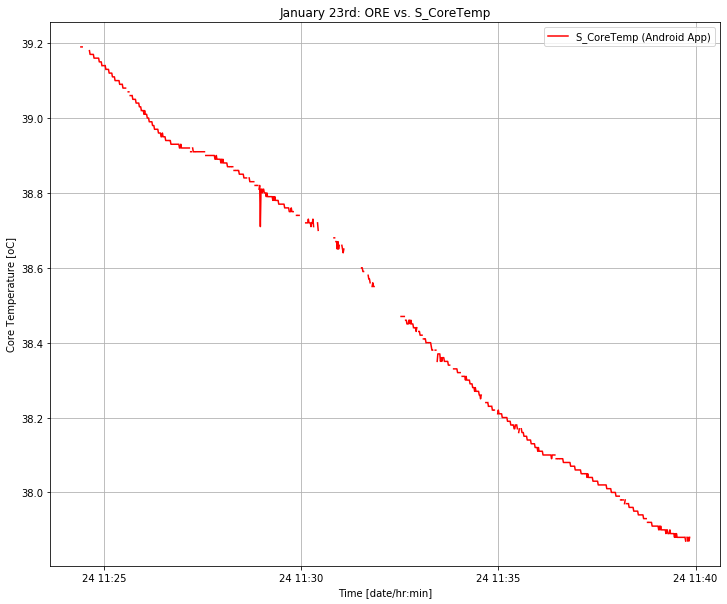

In [267]:
#Quick Plot
fig = plt.subplots(figsize = (12, 10))
plt.plot(df_score.index, df_score.temp, c = 'r', label = 'S_CoreTemp (Android App)')
plt.ylabel('Core Temperature [oC]')
plt.xlabel('Time [date/hr:min]')
plt.title('January 23rd: ORE vs. S_CoreTemp')
plt.legend()
plt.grid(True)




In [245]:
#join

data = df_score.join(df, how="outer")
data.head()

date android_time        freq message   temp  \
2021-01-24 10:17:36   Jan 24     10:17:36   262248.84    0x80    NaN   
2021-01-24 10:17:37   Jan 24     10:17:37   262248.94    0x80  37.46   
2021-01-24 10:17:38   Jan 24     10:17:38   262248.94    0x80  37.46   
2021-01-24 10:17:39   Jan 24     10:17:39   262249.03    0x80  37.47   
2021-01-24 10:17:40   Jan 24     10:17:40   262248.94    0x80  37.46   

                     cal_value  CoreTemp Est Core Temp  altitude  \
2021-01-24 10:17:36        NaN       NaN          None       NaN   
2021-01-24 10:17:37        NaN       NaN          None       NaN   
2021-01-24 10:17:38        NaN       NaN          None       NaN   
2021-01-24 10:17:39        NaN       NaN          None       NaN   
2021-01-24 10:17:40        NaN       NaN          None       NaN   

                     currHemoConc  ...  enhanced_altitude  enhanced_speed  \
2021-01-24 10:17:36           NaN  ...                NaN             NaN   
2021-01-24 10:17:37           NaN  ...                NaN             NaN   
2021-01-24 10:17:38           NaN  ...                NaN             NaN   
2021-01-24 10:17:39           NaN  ...                NaN             NaN   
2021-01-24 10:17:40           NaN  ...                NaN             NaN   

                     heart_rate  position_lat  position_long  speed  \
2021-01-24 10:17:36         NaN           NaN            NaN    NaN   
2021-01-24 10:17:37         NaN           NaN            NaN    NaN   
2021-01-24 10:17:38         NaN           NaN            NaN    NaN   
2021-01-24 10:17:39         NaN           NaN            NaN    NaN   
2021-01-24 10:17:40         NaN           NaN            NaN    NaN   

                     temperature  unknown_88  saturated_hemoglobin_percent  \
2021-01-24 10:17:36          NaN         NaN                           NaN   
2021-01-24 10:17:37          NaN         NaN                           NaN   
2021-01-24 10:17:38          NaN         NaN                           NaN   
2021-01-24 10:17:39          NaN         NaN                           NaN   
2021-01-24 10:17:40          NaN         NaN                           NaN   

                     total_hemoglobin_conc  
2021-01-24 10:17:36                    NaN  
2021-01-24 10:17:37                    NaN  
2021-01-24 10:17:38                    NaN  
2021-01-24 10:17:39                    NaN  
2021-01-24 10:17:40                    NaN  

[5 rows x 22 columns]

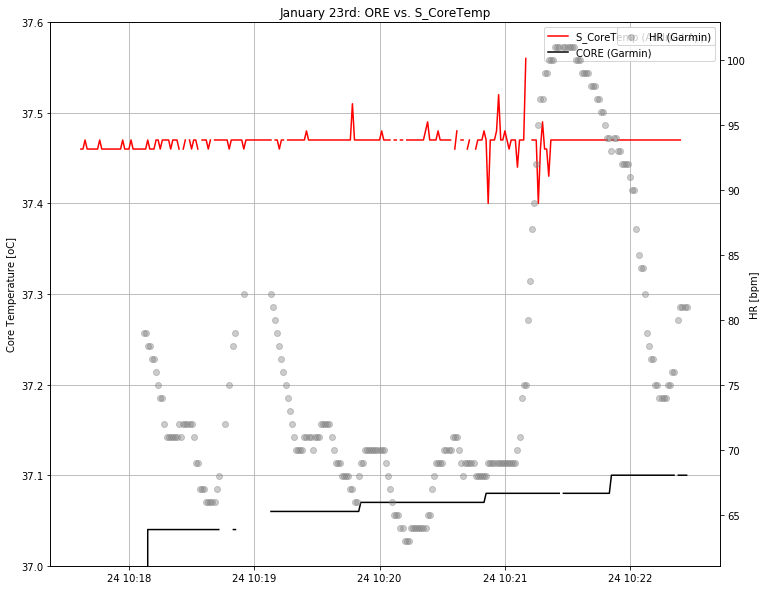

In [258]:
#HR filter (could be power)
#SG filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
#savgol_filter(input data, window size, polynomial order)

#hr_sg = signal.savgol_filter(data.heart_rate, 3, 2)


#Quick Plot
fig = plt.subplots(figsize = (12, 10))
plt.plot(data.index, data.temp, c = 'r', label = 'S_CoreTemp (Android App)')
plt.plot(data.index, data.CoreTemp, c = 'k',  label = 'CORE (Garmin)')
plt.ylabel('Core Temperature [oC]')
plt.ylim(37, 37.6)

plt.legend()
plt.grid(True)

plt2 =  plt.twinx() 
plt2.scatter(data.index, data.heart_rate, c = 'grey',  label = 'HR (Garmin)', alpha=0.4)
#plt2.plot(data.index, hr_sg, c = 'cyan',  label = 'HR (Garmin)')

plt.title('January 23rd: ORE vs. S_CoreTemp')
plt.xlabel('Time [date/hr:min]')
plt.ylabel('HR [bpm]')

plt.legend()

